In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Classic Machine Learning Techniques
Supervised Learning  -- correggi: intercation, iteration

In [2]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


### Data Preprocessing

In [3]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

# Train Test and Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

print('Number of training samples:', X_train.shape)
print('Number of testing samples:', X_test.shape)
print('Number of validation samples:', X_val.shape)

Number of training samples: (9934, 1147)
Number of testing samples: (2760, 1147)
Number of validation samples: (1104, 1147)


# Models
### Linear Regression

In [6]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Linear Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

Linear Regression Results:
Mean Square Error: 0.00532342232710311
R2 Score: 0.9763990355736916


### Ridge Regression

In [7]:
from sklearn.linear_model import Ridge

alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:
    i += 1
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X_train, y_train)
    y_pred = ridge_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = ridge_regressor

    results.append((i, alpha, mse))

    print(f'Iteration: {i} | Alpha: {alpha} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Ridge Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | Alpha: 0.001 | MSE: 0.0051

Iteration: 2 | Alpha: 0.01 | MSE: 0.0051

Iteration: 3 | Alpha: 0.1 | MSE: 0.0051

Iteration: 4 | Alpha: 0.5 | MSE: 0.0051

Iteration: 5 | Alpha: 1 | MSE: 0.0051

Iteration: 6 | Alpha: 5 | MSE: 0.0051

Iteration: 7 | Alpha: 10 | MSE: 0.0052

Ridge Regression Best Results:
Alpha: 1
Mean Square Error: 0.005090214586656228
R2 Score: 0.9767451183185097


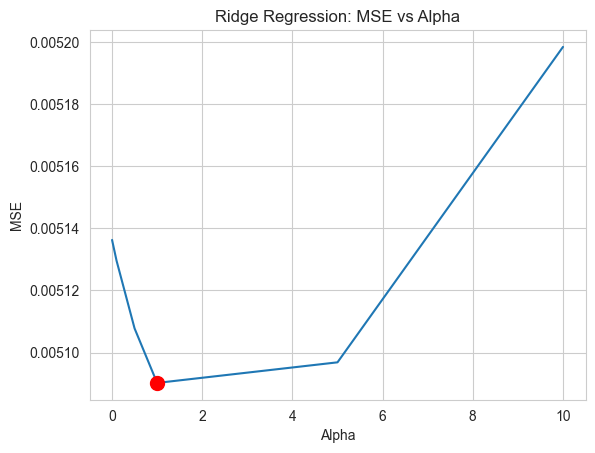

In [8]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Lasso Regression

In [9]:
from sklearn.linear_model import Lasso

alphas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:
    i += 1
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)
    y_pred = lasso_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = lasso_regressor

    results.append((i, alpha, mse))

    print(f'Iteration: {i} | Alpha: {alpha} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Lasso Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | Alpha: 0.01 | MSE: 0.0317

Iteration: 2 | Alpha: 0.001 | MSE: 0.0104



C:\Workspace\test\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.186e+00, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 3 | Alpha: 0.0001 | MSE: 0.0054



C:\Workspace\test\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 4 | Alpha: 1e-05 | MSE: 0.0051

Iteration: 5 | Alpha: 1e-06 | MSE: 0.0053

Lasso Regression Best Results:
Alpha: 1e-05
Mean Square Error: 0.005098755273247194
R2 Score: 0.9766021437075746


C:\Workspace\test\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


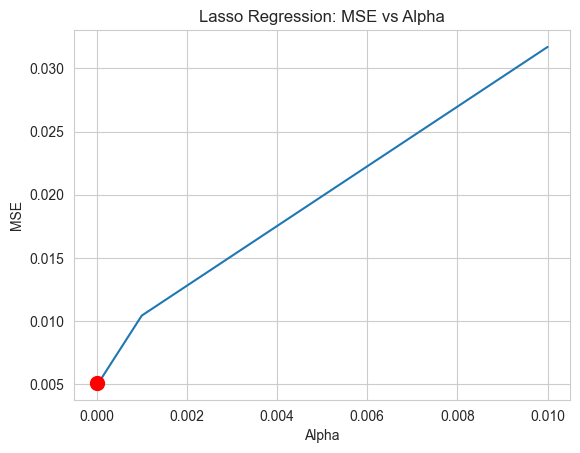

In [10]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Elastic Net Regression

In [11]:
from sklearn.linear_model import ElasticNet

alphas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:
    i += 1
    elastic_net_regressor = ElasticNet(alpha=alpha)
    elastic_net_regressor.fit(X_train, y_train)
    y_pred = elastic_net_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = elastic_net_regressor

    results.append((i, alpha, mse))

    print(f'Iteration: {i} | Alpha: {alpha} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Elastic Net Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | Alpha: 0.01 | MSE: 0.0217

Iteration: 2 | Alpha: 0.001 | MSE: 0.0081



C:\Workspace\test\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 3 | Alpha: 0.0001 | MSE: 0.0052



C:\Workspace\test\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 4 | Alpha: 1e-05 | MSE: 0.0052

Iteration: 5 | Alpha: 1e-06 | MSE: 0.0053

Elastic Net Regression Best Results:
Alpha: 0.0001
Mean Square Error: 0.005167175808787863
R2 Score: 0.9769949222547787


C:\Workspace\test\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


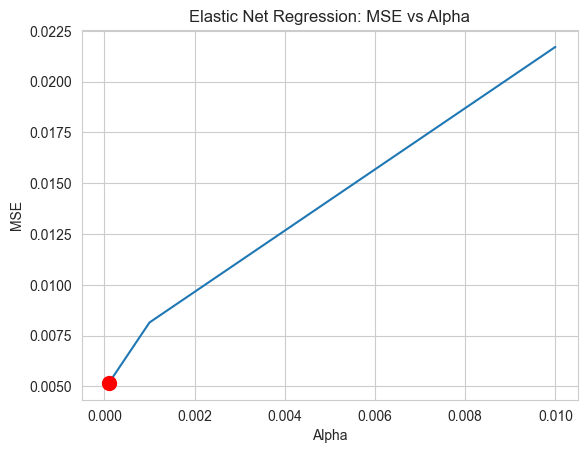

In [12]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Elastic Net Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
import itertools

n_est = [100, 150, 200]
criterion = ['squared_error', 'friedman_mse', 'poisson']

best_mse = None
best_estimator = None
best_model = None
best_criterion = None

results = []

i = 0
for n_est, criterion in itertools.product(n_est, criterion):
    i += 1
    rf_regressor = RandomForestRegressor(n_estimators=n_est, criterion=criterion, random_state=seed)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_estimator = n_est
        best_model = rf_regressor
        best_criterion = criterion

    results.append((i, n_est, criterion, mse))

    print(f'Iteration: {i} | N-Estimators: {n_est} | Criterion: {criterion} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Random Forest Regressor Best Results:')
print('N Trees:', best_estimator)
print('Criterion:', best_criterion)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | N-Estimators: 100 | Criterion: squared_error | MSE: 0.0132

Iteration: 2 | N-Estimators: 100 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 3 | N-Estimators: 100 | Criterion: poisson | MSE: 0.0134

Iteration: 4 | N-Estimators: 150 | Criterion: squared_error | MSE: 0.0132

Iteration: 5 | N-Estimators: 150 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 6 | N-Estimators: 150 | Criterion: poisson | MSE: 0.0133

Iteration: 7 | N-Estimators: 200 | Criterion: squared_error | MSE: 0.0132

Iteration: 8 | N-Estimators: 200 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 9 | N-Estimators: 200 | Criterion: poisson | MSE: 0.0133

Random Forest Regressor Best Results:
N Trees: 100
Criterion: friedman_mse
Mean Square Error: 0.013055440111680645
R2 Score: 0.9451656538746867


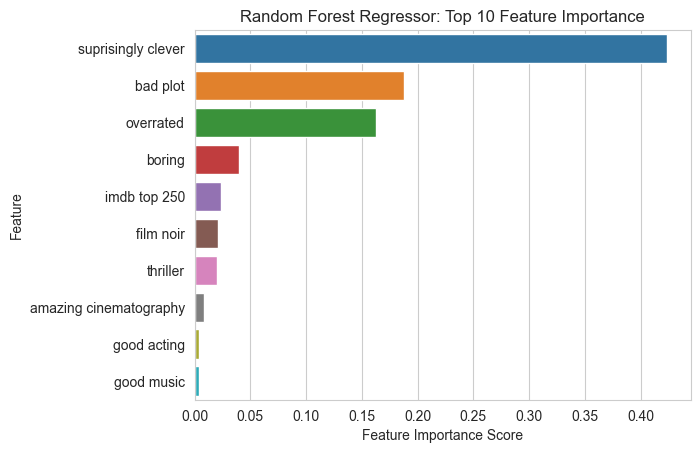

In [14]:
rankVar = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=rankVar[:10], y=rankVar.index[:10])
plt.title('Random Forest Regressor: Top 10 Feature Importance')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

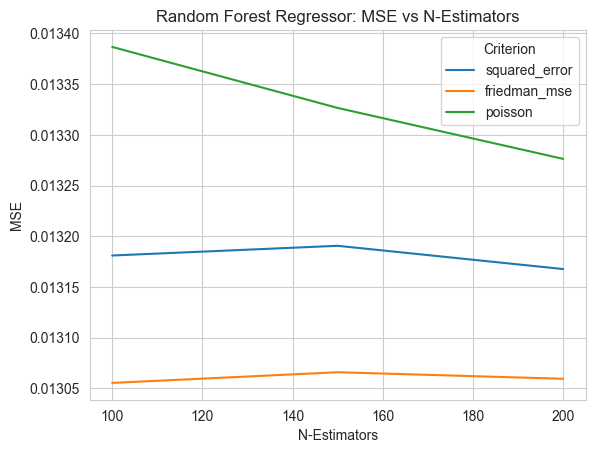

In [15]:
results = pd.DataFrame(results, columns=['Iteration', 'N-Estimators', 'Criterion', 'MSE'])

sns.lineplot(x='N-Estimators', y='MSE', hue='Criterion', data=results)
plt.xlabel('N-Estimators')
plt.ylabel('MSE')
plt.title('Random Forest Regressor: MSE vs N-Estimators')
# plt.scatter(best_n_trees, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Gradient Boosting Regressor

In [1]:
from sklearn.ensemble import GradientBoostingRegressor

n_est = [100, 150, 200]
criterion = 'friedman_mse'

best_mse = None
best_estimator = None
best_model = None
best_criterion = None

results = []

i = 0
for n_est, criterion in itertools.product(n_est, criterion):
    i += 1
    gb_regressor = GradientBoostingRegressor(n_estimators=n_est, criterion=criterion, random_state=seed)
    gb_regressor.fit(X_train, y_train)
    y_pred = gb_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_estimator = n_est
        best_model = gb_regressor
        best_criterion = criterion

    results.append((i, n_est, criterion, mse))

    print(f'Iteration: {i} | N-Estimators: {n_est} | Criterion: {criterion} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Gradient Boosting Regressor Best Results:')
print('N Trees:', best_estimator)
print('Criterion:', best_criterion)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

KeyboardInterrupt: 

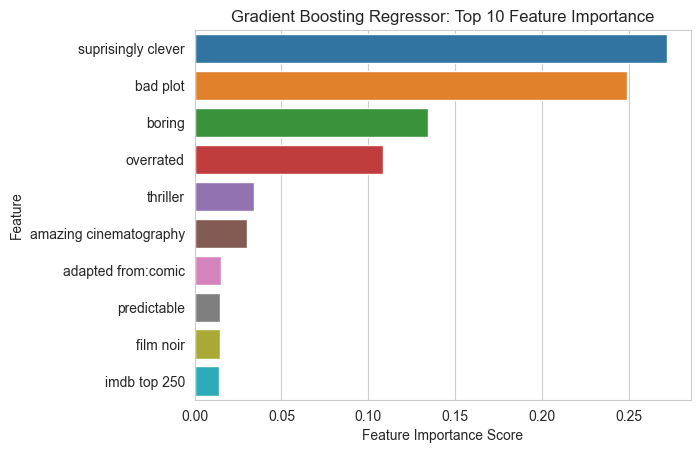

In [17]:
rankVar = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=rankVar[:10], y=rankVar.index[:10])
plt.title('Gradient Boosting Regressor: Top 10 Feature Importance')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

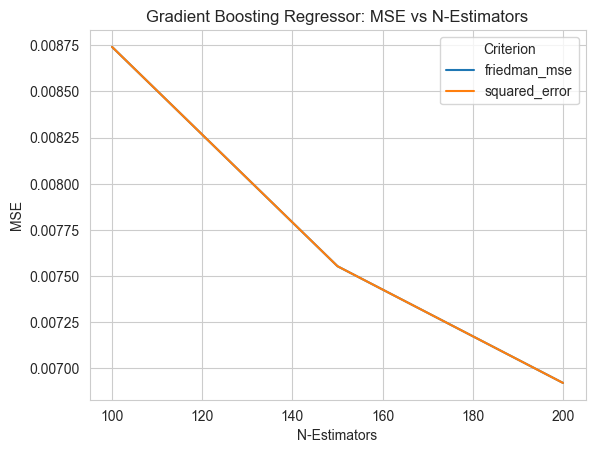

In [18]:
results = pd.DataFrame(results, columns=['Iteration', 'N-Estimators', 'Criterion', 'MSE'])

sns.lineplot(x='N-Estimators', y='MSE', hue='Criterion', data=results)
plt.xlabel('N-Estimators')
plt.ylabel('MSE')
plt.title('Gradient Boosting Regressor: MSE vs N-Estimators')
# plt.scatter(best_n_trees, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Support Vector Regressor

In [9]:
from sklearn.svm import SVR
import itertools

## da fixzare togliere 5
c = [0.001, 0.01, 0.1, 1]
epsilon = [0.001, 0.01, 0.1, 1]
kernel = ['linear', 'poly', 'rbf']

best_mse = None
best_c = None
best_epsilon = None
best_kernel = None
best_model = None

results = []

i = 0

for c_value, epsilon_value, kernel_value in itertools.product(c, epsilon, kernel):
    i += 1
    svr_regressor = SVR(C=c_value, epsilon=epsilon_value, kernel=kernel_value)
    svr_regressor.fit(X_train, y_train)
    y_pred = svr_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_c = c_value
        best_epsilon = epsilon_value
        best_kernel = kernel_value
        best_model = svr_regressor

    results.append((i, c_value, epsilon_value, kernel_value, mse))

    print(f'Iteration: {i} | C: {c_value} | Epsilon: {epsilon_value} | Kernel: {kernel_value} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Support Vector Regression Best Results:')
print('C:', best_c)
print('Epsilon:', best_epsilon)
print('Kernel:', best_kernel)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | C: 0.001 | Epsilon: 0.001 | Kernel: linear | MSE: 0.0082

Iteration: 2 | C: 0.001 | Epsilon: 0.001 | Kernel: poly | MSE: 0.0806

Iteration: 3 | C: 0.001 | Epsilon: 0.001 | Kernel: rbf | MSE: 0.1079

Iteration: 4 | C: 0.001 | Epsilon: 0.01 | Kernel: linear | MSE: 0.0083

Iteration: 5 | C: 0.001 | Epsilon: 0.01 | Kernel: poly | MSE: 0.0807

Iteration: 6 | C: 0.001 | Epsilon: 0.01 | Kernel: rbf | MSE: 0.1081

Iteration: 7 | C: 0.001 | Epsilon: 0.1 | Kernel: linear | MSE: 0.0107

Iteration: 8 | C: 0.001 | Epsilon: 0.1 | Kernel: poly | MSE: 0.0830

Iteration: 9 | C: 0.001 | Epsilon: 0.1 | Kernel: rbf | MSE: 0.1105

Iteration: 10 | C: 0.001 | Epsilon: 1 | Kernel: linear | MSE: 0.2563

Iteration: 11 | C: 0.001 | Epsilon: 1 | Kernel: poly | MSE: 0.2826

Iteration: 12 | C: 0.001 | Epsilon: 1 | Kernel: rbf | MSE: 0.2675

Iteration: 13 | C: 0.01 | Epsilon: 0.001 | Kernel: linear | MSE: 0.0054

Iteration: 14 | C: 0.01 | Epsilon: 0.001 | Kernel: poly | MSE: 0.0242

Iteration: 15 | C:

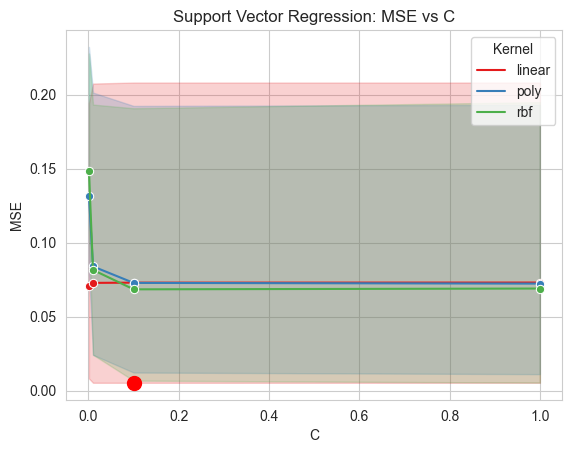

In [10]:
results = pd.DataFrame(results, columns=['Iteration', 'C', 'Epsilon', 'Kernel', 'MSE'])

sns.lineplot(x='C', y='MSE', hue='Kernel', data=results, palette='Set1', marker='o')
plt.xlabel('C')
plt.ylabel('MSE')
plt.title('Support Vector Regression: MSE vs C')
plt.scatter(best_c, best_mse, color='red', marker='o', s=100)
plt.show()

### K-Nearest Neighbors
è un classificatore non un regressore

In [30]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19]

best_mse = None
best_n_neighbors = None
best_model = None

results = []

i = 0
for n in n_neighbors:
    i += 1
    knn_classifier = KNeighborsRegressor(n_neighbors=n)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_n_neighbors = n
        best_model = knn_classifier

    results.append((i, n, mse))

    print(f'Iteration: {i} | N: {n} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('K-Nearest Neighbors Best Results:')
print('N:', best_n_neighbors)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | N: 3 | MSE: 0.0539

Iteration: 2 | N: 5 | MSE: 0.0479

Iteration: 3 | N: 7 | MSE: 0.0467

Iteration: 4 | N: 9 | MSE: 0.0455

Iteration: 5 | N: 11 | MSE: 0.0453

Iteration: 6 | N: 13 | MSE: 0.0457

Iteration: 7 | N: 15 | MSE: 0.0456

Iteration: 8 | N: 17 | MSE: 0.0461

Iteration: 9 | N: 19 | MSE: 0.0467

K-Nearest Neighbors Best Results:
N: 11
Mean Square Error: 0.045281859614944214
R2 Score: 0.7964074169165131


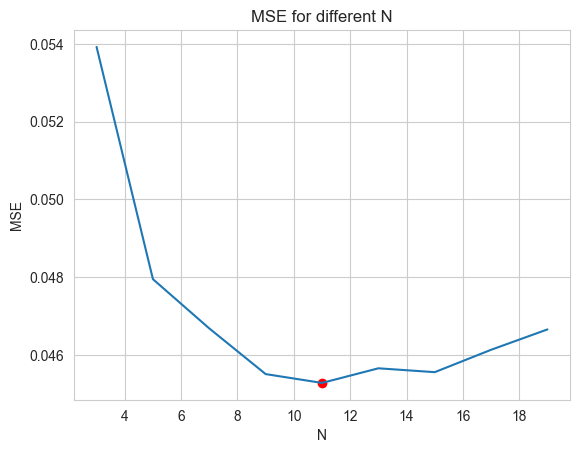

In [31]:
results = pd.DataFrame(results, columns=['Iteration', 'N', 'MSE'])

sns.lineplot(x='N', y='MSE', data=results)
plt.xlabel('N')
plt.ylabel('MSE')
plt.title('MSE for different N')
plt.scatter(best_n_neighbors, best_mse, color='red')
plt.show()